In [28]:
# --- CONFIG ---
BASE_DIR = "runs"   # root containing sub-run folders
DATASET  = "cifar10"          # filter token in folder name or config.json
SAVE_PNG = None               # e.g. "bayeslora/figs/ece_bar.png" or None

# --- IMPORTS ---
import os, re, json, glob, csv
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def detect_method(name: str) -> str:
    s = name.lower()
    if "vlora" in s or "bayeslora" in s:
        return "BayesLoRA"
    if "laplace" in s or "laplora" in s or "llora" in s:
        return "Laplace-LoRA"
    if "lora" in s:
        return "LoRA"
    return "Unknown"

def folder_matches_dataset(run_dir: str, dataset: str) -> bool:
    if dataset.lower() in os.path.basename(run_dir).lower():
        return True
    cfgp = os.path.join(run_dir, "config.json")
    if os.path.isfile(cfgp):
        try:
            with open(cfgp, "r") as f:
                cfg = json.load(f)
            return str(cfg.get("dataset","")).lower() == dataset.lower()
        except Exception:
            pass
    return False

def load_final_csv(run_dir: str) -> dict | None:
    path = os.path.join(run_dir, "final.csv")
    if not os.path.isfile(path):
        return None
    try:
        df = pd.read_csv(path)
        # We expect one row per run (your script appends a single final line per run)
        if len(df) == 0:
            return None
        # take the last line in case of duplicates
        row = df.iloc[-1].to_dict()
        return row
    except Exception:
        return None

# gather
rows_by_method = defaultdict(list)
for run_dir in sorted(glob.glob(os.path.join(BASE_DIR, "*"))):
    if not os.path.isdir(run_dir):
        continue
    if not folder_matches_dataset(run_dir, DATASET):
        continue
    final_row = load_final_csv(run_dir)
    if final_row is None:
        continue
    # method can be in 'variant' or folder name
    method = final_row.get("variant", None)
    if method is None:
        method = detect_method(run_dir)
    else:
        method = {"vlora":"BayesLoRA", "lora":"LoRA"}.get(str(method).lower(), method)
    if method == "Unknown":
        method = detect_method(run_dir)

    # keep only expected metrics if present
    keep = {
        "method": method,
        "run": final_row.get("run", os.path.basename(run_dir)),
        "ece_mean": final_row.get("ece_mean", np.nan),
        "ece_mc": final_row.get("ece_mc", np.nan),
        "acc_mean": final_row.get("acc_mean", np.nan),
        "nll_mean": final_row.get("nll_mean", np.nan),
        "total_rank_final": final_row.get("total_rank_final", np.nan),
        "adapter_params_final": final_row.get("adapter_params_final", np.nan),
    }
    rows_by_method[method].append(keep)

# assemble DataFrame
all_rows = [r for L in rows_by_method.values() for r in L]
df = pd.DataFrame(all_rows)
display(df.sort_values(["method","run"]))



,method,run,ece_mean,ece_mc,acc_mean,nll_mean,total_rank_final,adapter_params_final
5,BayesLoRA,cifar10_vlora_r8_seed123_main_20250912-110403,0.022279,0.014796,0.9334,0.208978,28,67152
6,BayesLoRA,cifar10_vlora_r8_seed123_main_20250912-120231,0.019797,0.010801,0.9341,0.206326,28,67152
7,BayesLoRA,cifar10_vlora_r8_seed123_main_20250912-132006,0.022801,0.013571,0.9315,0.216690,28,67152
8,BayesLoRA,cifar10_vlora_r8_seed123_main_20250913-075234,0.021765,0.014137,0.9349,0.209396,29,72272
9,BayesLoRA,cifar10_vlora_r8_seed123_main_20250913-085217,0.020064,0.013648,0.9366,0.205132,28,67152
0,LoRA,cifar10_lora_r3_seed123_lora3_20250912-103602,0.025442,0.025442,0.9325,0.217284,33,96030
1,LoRA,cifar10_lora_r3_seed123_lora3_20250912-113316,0.023503,0.023503,0.9350,0.217263,33,96030
2,LoRA,cifar10_lora_r3_seed123_lora3_20250912-123436,0.025847,0.025847,0.9338,0.210416,33,96030
3,LoRA,cifar10_lora_r3_seed123_lora3_20250913-082414,0.023031,0.023031,0.9355,0.203760,33,96030
4,LoRA,cifar10_lora_r3_seed123_lora3_20250913-092037,0.023078,0.023078,0.9370,0.200224,33,96030


In [29]:
import torch, torch.nn.functional as F
from copy import deepcopy
import numpy as np

from bayeslora_resnet import (
    Config,
    make_loaders,
    build_resnet18_with_adapters,
    calibration_metrics,
    set_bayeslora_sampling,
)

# You need access to your dataset loaders and builder, e.g. from your module:
# from bayeslora_resnet import make_loaders, build_resnet18_with_adapters, Config, calibration_metrics, set_bayeslora_sampling
# (Assumes these are already in your notebook's namespace if you imported the script.)


def _adapter_params(model):
    params, names = [], []
    for n,p in model.named_parameters():
        ln = n.lower()
        if any(k in ln for k in ["lora_", "loraa", "lorab", "adapter", ".a.", ".b."]):
            params.append(p)
            names.append(n)
    return params, names

def _empirical_fisher_diag(model, loader, device, params, num_batches=20):
    model.eval()
    diag = [torch.zeros_like(p, device=device) for p in params]
    count = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb, reduction="mean")
        grads = torch.autograd.grad(loss, params, retain_graph=False, create_graph=False)
        for d, g in zip(diag, grads):
            d.add_(g.detach()**2)
        count += 1
        if count >= num_batches:
            break
    for d in diag:
        d.div_(max(1, count))
    return diag

def _metrics_from_probs(probs, labels, n_bins=15):
    nll = F.nll_loss((probs + 1e-12).log(), labels, reduction='mean').item()
    one_hot = F.one_hot(labels, num_classes=probs.shape[1]).float()
    brier = torch.mean(torch.sum((probs - one_hot) ** 2, dim=1)).item()
    conf, preds = probs.max(1)
    accs = preds.eq(labels)
    bins = torch.linspace(0, 1, n_bins + 1)
    ece = torch.zeros(1)
    for i in range(n_bins):
        mask = (conf > bins[i]) & (conf <= bins[i+1])
        if mask.sum() > 0:
            acc_bin = accs[mask].float().mean()
            conf_bin = conf[mask].mean()
            ece += (mask.float().mean() * (conf_bin - acc_bin).abs())
    return float(ece.item()), float(nll), float(brier)

def laplace_ece_for_lora_checkpoint(
    ckpt_path: str,
    dataset: str = "cifar10",
    batch_size: int = 256,
    fisher_batches: int = 50,       # ↑ use more Fisher batches for stability
    mc_samples: int = 20,
    prior_var: float = 1.0,         # Gaussian prior variance on adapter params
    init_scale: float = 0.05,       # initial posterior variance multiplier
    std_cap: float = 1e-2,          # clamp per-param std to avoid explosions
    retry_shrink: float = 0.1,      # shrink factor if diagnostics look bad
    max_retries: int = 3,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
):
    # --- Load checkpoint + cfg + build LoRA model (MAP) ---
    payload = torch.load(ckpt_path, map_location="cpu")
    cfg = Config(**payload["cfg"])
    cfg.dataset = dataset
    tr, te = make_loaders(cfg.dataset, batch_size)
    num_classes = 100 if cfg.dataset.lower()=="cifar100" else 10
    model = build_resnet18_with_adapters("lora", cfg, num_classes).to(device)
    model.load_state_dict(payload["state_dict"], strict=False)
    model.eval()

    # --- Collect adapter params ---
    params, _ = _adapter_params(model)
    if not params:
        raise RuntimeError("No LoRA adapter parameters found in checkpoint.")

    # --- Fisher diag (empirical) ---
    diag_f = _empirical_fisher_diag(model, tr, device, params, num_batches=fisher_batches)
    post_var = [1.0 / (d + (1.0/prior_var)) for d in diag_f]

    with torch.no_grad():
        flat_std_raw = torch.cat([v.sqrt().flatten().cpu() for v in post_var])
        print(f"[Laplace] raw posterior std median/mean/max: "
              f"{flat_std_raw.median().item():.3e} / {flat_std_raw.mean().item():.3e} / {flat_std_raw.max().item():.3e}")

    # keep MAP weights for restoration
    base_tensors = [p.detach().clone() for p in params]

    # --- MAP metrics ---
    set_bayeslora_sampling(model, False)
    probs_map_list, labels_list = [], []
    with torch.no_grad():
        for xb, yb in te:
            xb = xb.to(device)
            probs_map_list.append(F.softmax(model(xb), dim=1).cpu())
            labels_list.append(yb)
    probs_map = torch.cat(probs_map_list, 0)
    labels_all = torch.cat(labels_list, 0)
    ece_map, nll_map, brier_map = _metrics_from_probs(probs_map, labels_all)

    # Helper: build MC predictive probs for a given scale (with clamped std)
    def mc_probs_for_scale(scale: float):
        probs_mc_list = []
        with torch.no_grad():
            for xb, _ in te:
                xb = xb.to(device)
                ps = []
                for _ in range(mc_samples):
                    for p, var, base in zip(params, post_var, base_tensors):
                        std = torch.sqrt(scale * var + 1e-12)
                        if std_cap is not None:
                            std = torch.clamp(std, max=std_cap)
                        eps = torch.randn_like(p, device=device)
                        p.copy_(base + eps * std)
                    ps.append(F.softmax(model(xb), dim=1))
                # restore MAP for next batch
                for p, base in zip(params, base_tensors):
                    p.copy_(base)
                probs_mc_list.append(torch.stack(ps, 0).mean(0).cpu())
        return torch.cat(probs_mc_list, 0)

    # --- Adaptive scale selection to avoid degenerate samples ---
    scale = init_scale
    retries = 0
    while True:
        probs_mc = mc_probs_for_scale(scale)
        ece_mc, nll_mc, brier_mc = _metrics_from_probs(probs_mc, labels_all)

        # Diagnostics: uniform-ish predictive or absurd NLL/Brier ⇒ shrink and retry
        avg_conf = probs_mc.max(1).values.mean().item()
        if (nll_mc > 2.0 or brier_mc > 0.5 or avg_conf < 0.2) and retries < max_retries:
            print(f"[Laplace] MC looks unstable (scale={scale:.3g}, "
                  f"NLL={nll_mc:.3f}, Brier={brier_mc:.3f}, avg_conf={avg_conf:.3f}) → shrinking scale")
            scale *= retry_shrink
            retries += 1
            continue
        break

    print(f"[Laplace] final scale={scale:.3g} | MC: ECE={ece_mc:.4f}, NLL={nll_mc:.4f}, Brier={brier_mc:.4f}, avg_conf={avg_conf:.3f}")

    return {
        "ece_mean": float(ece_map),
        "nll_mean": float(nll_map),
        "brier_mean": float(brier_map),
        "ece_mc": float(ece_mc),
        "nll_mc": float(nll_mc),
        "brier_mc": float(brier_mc),
        "scale_used": float(scale),
    }

In [30]:
lap_stats

{'ece_mean': 0.02307824417948723,
 'nll_mean': 0.20022395253181458,
 'brier_mean': 0.09475837647914886,
 'ece_mc': 0.013261783868074417,
 'nll_mc': 0.18960782885551453,
 'brier_mc': 0.09294413775205612,
 'scale_used': 0.05}

In [31]:
df2 = df[df['method'] == 'LoRA']
df2['method'] = 'LaplaceLoRA'
df1 = df.copy()

for index, row in df2.iterrows():
    ckpt = f"runs/{row['run']}/best_acc.pt"
    lap_stats = laplace_ece_for_lora_checkpoint(ckpt, dataset="cifar10", mc_samples=20, fisher_batches=10)
    df2.loc[index, 'ece_mean'] = lap_stats['ece_mean']
    df2.loc[index, 'ece_mc'] = lap_stats['ece_mc']
    df2.loc[index, 'nll_mean'] = lap_stats['nll_mean']

df = pd.concat([df, df2]).reset_index(drop=True)
df

/tmp/ipykernel_1532/3650819770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['method'] = 'LaplaceLoRA'


[Laplace] raw posterior std median/mean/max: 1.000e+00 / 1.000e+00 / 1.000e+00
[Laplace] final scale=0.05 | MC: ECE=0.0136, NLL=0.1990, Brier=0.0954, avg_conf=0.949
[Laplace] raw posterior std median/mean/max: 1.000e+00 / 1.000e+00 / 1.000e+00
[Laplace] final scale=0.05 | MC: ECE=0.0114, NLL=0.1924, Brier=0.0933, avg_conf=0.946
[Laplace] raw posterior std median/mean/max: 1.000e+00 / 1.000e+00 / 1.000e+00
[Laplace] final scale=0.05 | MC: ECE=0.0128, NLL=0.1970, Brier=0.0953, avg_conf=0.947
[Laplace] raw posterior std median/mean/max: 1.000e+00 / 1.000e+00 / 1.000e+00
[Laplace] final scale=0.05 | MC: ECE=0.0150, NLL=0.1920, Brier=0.0955, avg_conf=0.947
[Laplace] raw posterior std median/mean/max: 1.000e+00 / 1.000e+00 / 1.000e+00
[Laplace] final scale=0.05 | MC: ECE=0.0130, NLL=0.1894, Brier=0.0927, avg_conf=0.949


,method,run,ece_mean,ece_mc,acc_mean,nll_mean,total_rank_final,adapter_params_final
0,LoRA,cifar10_lora_r3_seed123_lora3_20250912-103602,0.025442,0.025442,0.9325,0.217284,33,96030
1,LoRA,cifar10_lora_r3_seed123_lora3_20250912-113316,0.023503,0.023503,0.9350,0.217263,33,96030
2,LoRA,cifar10_lora_r3_seed123_lora3_20250912-123436,0.025847,0.025847,0.9338,0.210416,33,96030
3,LoRA,cifar10_lora_r3_seed123_lora3_20250913-082414,0.023031,0.023031,0.9355,0.203760,33,96030
4,LoRA,cifar10_lora_r3_seed123_lora3_20250913-092037,0.023078,0.023078,0.9370,0.200224,33,96030
5,BayesLoRA,cifar10_vlora_r8_seed123_main_20250912-110403,0.022279,0.014796,0.9334,0.208978,28,67152
6,BayesLoRA,cifar10_vlora_r8_seed123_main_20250912-120231,0.019797,0.010801,0.9341,0.206326,28,67152
7,BayesLoRA,cifar10_vlora_r8_seed123_main_20250912-132006,0.022801,0.013571,0.9315,0.216690,28,67152
8,BayesLoRA,cifar10_vlora_r8_seed123_main_20250913-075234,0.021765,0.014137,0.9349,0.209396,29,72272
9,BayesLoRA,cifar10_vlora_r8_seed123_main_20250913-085217,0.020064,0.013648,0.9366,0.205132,28,67152


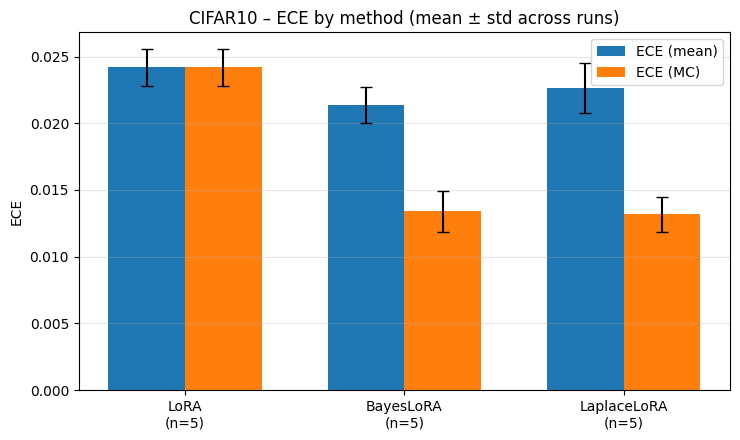

In [32]:
# aggregate means / stds
def agg_stats(method, col):
    sub = df[(df["method"]==method) & df[col].notna()]
    if len(sub)==0:
        return np.nan, np.nan, 0
    return sub[col].mean(), sub[col].std(ddof=1) if len(sub)>1 else 0.0, len(sub)

methods = df['method'].unique()
ece_mean_stats = [agg_stats(m, "ece_mean") for m in methods]
ece_mc_stats   = [agg_stats(m, "ece_mc")   for m in methods]

# bar plot (grouped): ECE(mean) and ECE(MC)
x = np.arange(len(methods))
w = 0.35

fig, ax = plt.subplots(figsize=(7.5,4.5))
m_means = [m for m,s,n in ece_mean_stats]
m_stds  = [s for m,s,n in ece_mean_stats]
mc_means= [m for m,s,n in ece_mc_stats]
mc_stds = [s for m,s,n in ece_mc_stats]

bar1 = ax.bar(x - w/2, m_means, yerr=m_stds, width=w, capsize=4, label="ECE (mean)")
bar2 = ax.bar(x + w/2, mc_means, yerr=mc_stds, width=w, capsize=4, label="ECE (MC)")

ax.set_xticks(x)
# annotate with counts
labels = []
for i,m in enumerate(methods):
    n1 = ece_mean_stats[i][2]
    labels.append(f"{m}\n(n={n1})")
ax.set_xticklabels(labels)
ax.set_ylabel("ECE")
ax.set_title(f"{DATASET.upper()} – ECE by method (mean ± std across runs)")
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
if SAVE_PNG:
    os.makedirs(os.path.dirname(SAVE_PNG), exist_ok=True)
    plt.savefig(SAVE_PNG, dpi=200, bbox_inches="tight")
    print("Saved:", SAVE_PNG)
plt.show()

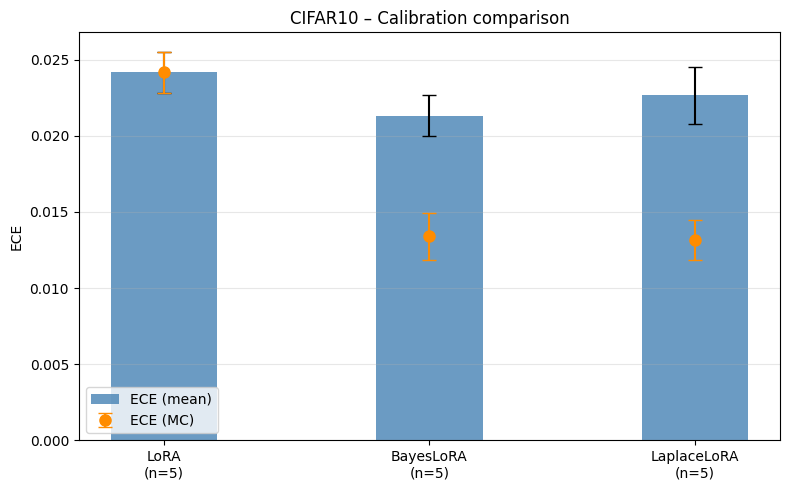

In [38]:
import matplotlib.pyplot as plt
import numpy as np

methods = df['method'].unique()
ece_mean_stats = [agg_stats(m, "ece_mean") for m in methods]
ece_mc_stats   = [agg_stats(m, "ece_mc")   for m in methods]

x = np.arange(len(methods))
w = 0.4

fig, ax = plt.subplots(figsize=(8, 5))

# mean bars
m_means = [m for m,s,n in ece_mean_stats]
m_stds  = [s for m,s,n in ece_mean_stats]
bars = ax.bar(x, m_means, yerr=m_stds, width=w, capsize=5, label="ECE (mean)", 
              color="steelblue", alpha=0.8)

# mc dots
mc_means = [m for m,s,n in ece_mc_stats]
mc_stds  = [s for m,s,n in ece_mc_stats]
ax.errorbar(x, mc_means, yerr=mc_stds, fmt='o', color="darkorange", 
            ecolor="darkorange", capsize=5, markersize=8, label="ECE (MC)")

# labels
labels = [f"{m}\n(n={ece_mean_stats[i][2]})" for i,m in enumerate(methods)]
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("ECE")
ax.set_title(f"{DATASET.upper()} – Calibration comparison")
ax.legend()
ax.grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()